# CLIP evaluation

For each classifier:

Use clip to find the minimum number of coefficients needed to edit both ways + baseline (from multiple ppl)
- Select a sample of faces
- Generate baseline
- Select a subset of coefficients from clf (based on?)
- Generate edits on the coefficients
- Use clip

Generate examples to show


## Setup

In [53]:
import torch
import numpy as np
from notebooks.utils import *
from sae.sae import EncoderOutput

from transformers import CLIPProcessor, CLIPModel

In [2]:
path = "weights2weights/weights_datasets"
device = "cuda"

In [3]:
base_weights, pipe = load_diffusion()
prompt, ddim_steps, guidance_scale, negative_prompt, latents = get_diffusion_params(pipe)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/net/tscratch/people/plgkingak/w2w/lib/python3.12/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/net/tscratch/people/plgkingak/w2w/lib/python3.12/site-packages/peft/tuners/lora/model.py:364: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  return getattr(self.model, name)


In [4]:
sae = load_sae("runs/test_feature_logging/0")

In [5]:
df = torch.load(f"{path}/identities/identity_df.pt")
df["filename"] = df.index.str.split(".").str[0]

In [7]:
scaler = torch.load("notebooks/scaler.pt")
clf = torch.load("notebooks/clf_bushy.pt")

## 1. Sample

In [6]:
sample = torch.load(path + '/single/0/'+ df.index[1].replace('jpg', 'pt'))

## 2. Baseline (and errors)

In [8]:
err, gt_weights, rec_weights = get_error(sae, sample, base_weights, True)

  0%|          | 0/50 [00:00<?, ?it/s]

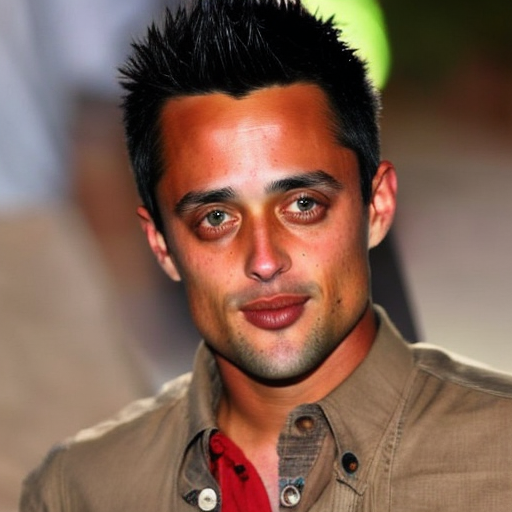

In [50]:
baseline = get_image(gt_weights, pipe, prompt, ddim_steps, guidance_scale, negative_prompt,latents)
baseline

## 3. Select a subset of coeeficients

In [176]:
w = clf.coef_.flatten()
i = np.abs(w).argsort()[-2:]
i

array([ 674, 1479])

## 4. Generate edits

In [171]:
x = scaler.transform(sae.pre_acts(sample).unsqueeze(0).cpu().detach())[0]

In [172]:
x.shape

(5000,)

In [177]:
imgs = []
# for eta in (-8,-6, -4, -2, +2, +4, +6, +8):
for eta in (-80, +80):
    x_mod = x.copy()
    x_mod[i] = x_mod[i] + eta*w[i]
    x_mod = scaler.inverse_transform(x_mod.reshape(1,-1))
    x_orig = scaler.inverse_transform(x.reshape(1,-1))

    acts= torch.tensor(x_orig[0])
    k = 1000
    indices = acts.topk(k).indices
    acts = torch.tensor(x_mod[0])[indices] 
    e2 = EncoderOutput(top_acts=acts.to(device),
                        top_indices=indices.to(device))
    weights_out = sae.decode(e2.top_acts, e2.top_indices)
    weights_out = array_to_dict(weights_out, base_weights)
    im = get_image(add_error(err, weights_out), pipe, prompt, ddim_steps, guidance_scale, negative_prompt,latents)
    imgs.append(im)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

## 5. Use clip

#### Load

In [230]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [56]:
attributes = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young']


In [73]:
clip_prompts = [
    "a person who has a 5 o'clock shadow",
    "a person who has arched eyebrows",
    "a person who is attractive",
    "a person who has bags under their eyes",
    "a person who is bald",
    "a person who has bangs",
    "a person who has big lips",
    "a person who has a big nose",
    "a person who has black hair",
    "a person who has blond hair",
    "a person who appears blurry",
    "a person who has brown hair",
    "a person who has bushy eyebrows",
    "a person who is chubby",
    "a person who has a double chin",
    "a person who is wearing eyeglasses",
    "a person who has a goatee",
    "a person who has gray hair",
    "a person who is wearing heavy makeup",
    "a person who has high cheekbones",
    "a person who is male",
    "a person whose mouth is slightly open",
    "a person who has a mustache",
    "a person who has narrow eyes",
    "a person who has no beard",
    "a person who has an oval-shaped face",
    "a person who has pale skin",
    "a person who has a pointy nose",
    "a person who has a receding hairline",
    "a person who has rosy cheeks",
    "a person who has sideburns",
    "a person who is smiling",
    "a person who has straight hair",
    "a person who has wavy hair",
    "a person who is wearing earrings",
    "a person who is wearing a hat",
    "a person who is wearing lipstick",
    "a person who is wearing a necklace",
    "a person who is wearing a necktie",
    "a person who is young"
]

#### Use

In [185]:
clip_prompts = ["a photo of a dog", "a photo of a cat", "a photo of a person"]

In [186]:
mid = len(imgs)//2
imgs = imgs[:mid] + [baseline] + imgs[-mid:]

In [187]:
for im in imgs: 
    inputs = processor(text=clip_prompts, images=im, return_tensors="pt", padding=True)

    with torch.no_grad():
        outputs = model(**inputs)
        image_embed = torch.nn.functional.normalize(outputs.image_embeds, p=2, dim=-1)  # shape: (1, 512)
        text_embeds = torch.nn.functional.normalize(outputs.text_embeds, p=2, dim=-1) 

    similarities = (text_embeds @ image_embed.T).squeeze()  # shape: (num_texts,)

    top_k = len(similarities) #10  # or all
    top_indices = similarities.topk(top_k).indices

    for idx in top_indices:
        if attributes[idx] == "Bushy_Eyebrows":
            print(f"{attributes[idx]}: {similarities[idx].item():.4f}")

In [195]:
import requests
from io import BytesIO
from PIL import Image

In [207]:
url = "https://thispersondoesnotexist.com/"
response = requests.get(url)
image = Image.open(BytesIO(response.content)).convert("RGB")

In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

inputs = processor(
    text=["dog", "car", "person"], images=image, return_tensors="pt", padding=False
)

with torch.no_grad():
    image_features = model.get_image_features(pixel_values=inputs["pixel_values"])
    text_features = model.get_text_features(input_ids=inputs["input_ids"], 
                                            attention_mask=inputs["attention_mask"])

similarities = torch.nn.functional.cosine_similarity(text_features, image_features)
print(similarities) 

tensor([0.1721, 0.1847, 0.2050])
